In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.compat.v1.keras.layers import BatchNormalization
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
tf.__version__

'2.2.0'

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

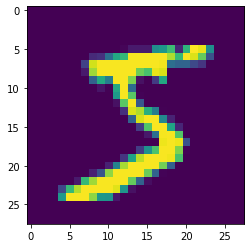

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
plt.imshow(x_train[0])

In [5]:
scaler = MinMaxScaler((-1,1))

In [19]:
def create_generator(verbose=False):
#     initializer = keras.initializers.RandomNormal(0,0.02)
    initializer = None
    
    generator = keras.Sequential()
    n_nodes = 128 * 7 * 7
    generator.add(keras.layers.Dense(n_nodes, input_dim=100, kernel_initializer= initializer))
    # generator.add(keras.layers.BatchNormalization())
    generator.add(keras.layers.LeakyReLU(0.2))
    generator.add(keras.layers.Reshape((7,7,128)))
    generator.add(keras.layers.Conv2DTranspose(128, (3,3), strides=2, padding='same', kernel_initializer= initializer))
    generator.add(keras.layers.BatchNormalization(momentum=0.8))
    generator.add(keras.layers.LeakyReLU(0.2))
    generator.add(keras.layers.Conv2DTranspose(64, (3,3), strides=1, padding='same', kernel_initializer= initializer))
    generator.add(keras.layers.BatchNormalization(momentum=0.8))
    generator.add(keras.layers.LeakyReLU(0.2))
    generator.add(keras.layers.Conv2DTranspose(1, (3,3), strides=2, activation='tanh', padding='same', kernel_initializer= initializer))
    
    if verbose:
        generator.summary()
    
    return generator

In [20]:
def create_discriminator(verbose=False, dropout=False):
#     initializer = keras.initializers.RandomNormal(0,0.02)
    initializer = None

    discriminator = keras.Sequential()
    discriminator.add(keras.layers.Conv2D(32, (3,3), strides=(2,2), padding='same', input_shape=(28,28,1), kernel_initializer= initializer))
    # discriminator.add(keras.layers.BatchNormalization())
    discriminator.add(keras.layers.LeakyReLU(0.2))
    discriminator.add(keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer= initializer))
    discriminator.add(keras.layers.BatchNormalization(momentum=0.8))
    discriminator.add(keras.layers.LeakyReLU(0.2))
    if dropout:
        discriminator.add(keras.layers.Dropout(0.25))
    discriminator.add(keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer= initializer))
    discriminator.add(keras.layers.BatchNormalization(momentum=0.8))
    discriminator.add(keras.layers.LeakyReLU(0.2))
    if dropout:
        discriminator.add(keras.layers.Dropout(0.25))
    discriminator.add(keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer= initializer))
    discriminator.add(keras.layers.BatchNormalization(momentum=0.8))
    discriminator.add(keras.layers.LeakyReLU(0.2))
    if dropout:
        discriminator.add(keras.layers.Dropout(0.25))
    discriminator.add(keras.layers.Flatten())
    discriminator.add(keras.layers.Dense(1, activation='sigmoid', kernel_initializer= initializer))

    if verbose:
        discriminator.summary()
    discriminator.compile(loss='binary_crossentropy', 
                          optimizer=keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])
    
    return discriminator

In [21]:
def create_gan(verbose=False, dropout=False):
    gan_model = keras.Sequential()
    generator = create_generator(verbose)
    discriminator = create_discriminator(verbose, dropout)
    discriminator.trainable = False
    gan_model.add(generator)
    gan_model.add(discriminator)
    gan_model.summary()
    gan_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.0002, 0.5))
    return gan_model, discriminator, generator

In [22]:
def generate_latent_points(latent_dim, n_batch, seed=None):
    np.random.seed(seed)
    return np.random.normal(size=(n_batch, latent_dim))

In [23]:
def generate_fake_images(generator, latent_dim, n_batch, seed=None):
    latent_points = generate_latent_points(latent_dim, n_batch, seed)
    return generator.predict(latent_points), np.zeros(shape=(n_batch,1))

In [24]:
def select_real_samples(dataset, n_batch):
    random_indice = np.random.randint(0,high=dataset.shape[0],size=n_batch)
    batch = x_train[random_indice]
    batch_scaled = scaler.fit_transform(batch.reshape(-1,28*28)).reshape(-1,28,28)
    return np.expand_dims(batch_scaled, axis=-1), np.ones(shape=(n_batch,1))

In [25]:
def print_images(model, n_img, seed=None):
    img, _ = generate_fake_images(model, latent_dim, n_img, seed=seed)
    fig, ax = plt.subplots(1, n_img)
    for en, i in enumerate(img):
        ax[en].imshow(i, cmap='gray') 
    plt.show()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 64)       

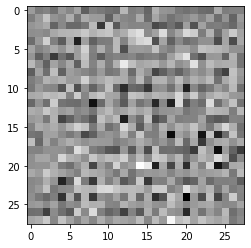

In [26]:
generator = create_generator(True)
fake_image, label = generate_fake_images(generator, 100, 1)
plt.imshow(fake_image[0], cmap='gray')

In [28]:
n_batch = 128
latent_dim = 100
n_epochs = 20000
save_step = 5000
print_step = 500
n_img = 6

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 14, 14, 64)       

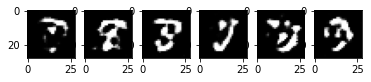

Epoch number: 1000
discriminator loss: 0.19 discriminator acc: 92.58 %
gan loss: 4.87


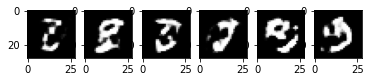

Epoch number: 1500
discriminator loss: 0.31 discriminator acc: 86.33 %
gan loss: 4.0


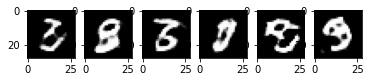

Epoch number: 2000
discriminator loss: 0.41 discriminator acc: 82.81 %
gan loss: 1.96


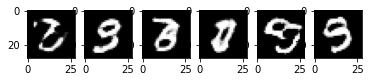

Epoch number: 2500
discriminator loss: 0.33 discriminator acc: 86.72 %
gan loss: 7.23


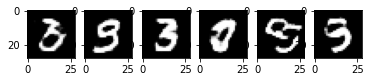

Epoch number: 3000
discriminator loss: 0.37 discriminator acc: 85.16 %
gan loss: 7.72


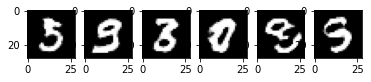

Epoch number: 3500
discriminator loss: 0.43 discriminator acc: 76.95 %
gan loss: 1.57


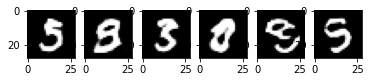

Epoch number: 4000
discriminator loss: 0.42 discriminator acc: 81.25 %
gan loss: 3.04


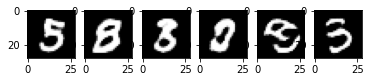

Epoch number: 4500
discriminator loss: 0.48 discriminator acc: 78.52 %
gan loss: 1.97


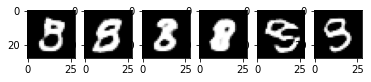

Epoch number: 5000
discriminator loss: 0.42 discriminator acc: 77.73 %
gan loss: 4.26


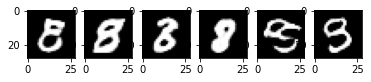

INFO:tensorflow:Assets written to: gen_5000/assets
Epoch number: 5500
discriminator loss: 0.36 discriminator acc: 84.77 %
gan loss: 1.1


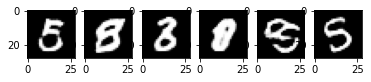

Epoch number: 6000
discriminator loss: 0.12 discriminator acc: 96.09 %
gan loss: 0.36


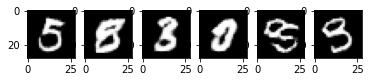

Epoch number: 6500
discriminator loss: 0.32 discriminator acc: 85.55 %
gan loss: 2.73


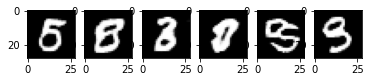

Epoch number: 7000
discriminator loss: 0.22 discriminator acc: 90.62 %
gan loss: 4.03


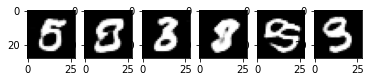

Epoch number: 7500
discriminator loss: 0.19 discriminator acc: 92.58 %
gan loss: 9.96


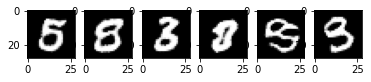

Epoch number: 8000
discriminator loss: 0.12 discriminator acc: 96.09 %
gan loss: 6.99


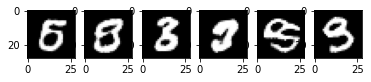

Epoch number: 8500
discriminator loss: 0.25 discriminator acc: 91.8 %
gan loss: 11.24


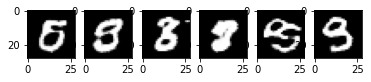

Epoch number: 9000
discriminator loss: 0.24 discriminator acc: 90.23 %
gan loss: 0.36


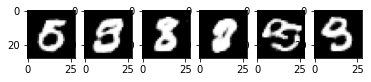

Epoch number: 9500
discriminator loss: 0.13 discriminator acc: 94.92 %
gan loss: 0.47


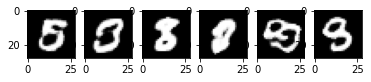

Epoch number: 10000
discriminator loss: 0.35 discriminator acc: 87.5 %
gan loss: 5.18


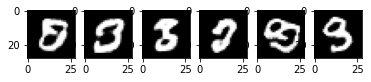

INFO:tensorflow:Assets written to: gen_10000/assets
Epoch number: 10500
discriminator loss: 0.13 discriminator acc: 95.7 %
gan loss: 6.97


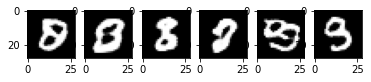

Epoch number: 11000
discriminator loss: 0.13 discriminator acc: 93.75 %
gan loss: 0.88


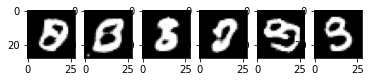

Epoch number: 11500
discriminator loss: 0.11 discriminator acc: 96.48 %
gan loss: 0.09


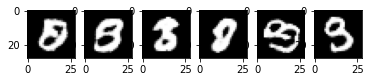

Epoch number: 12000
discriminator loss: 0.1 discriminator acc: 96.88 %
gan loss: 7.48


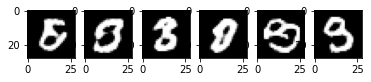

Epoch number: 12500
discriminator loss: 0.17 discriminator acc: 94.14 %
gan loss: 2.1


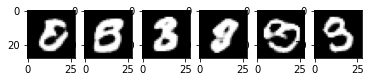

Epoch number: 13000
discriminator loss: 0.14 discriminator acc: 94.14 %
gan loss: 0.06


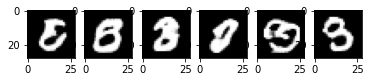

Epoch number: 13500
discriminator loss: 0.12 discriminator acc: 95.7 %
gan loss: 0.09


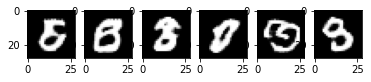

Epoch number: 14000
discriminator loss: 0.17 discriminator acc: 91.02 %
gan loss: 11.31


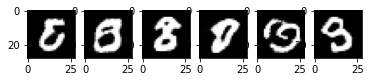

Epoch number: 14500
discriminator loss: 0.13 discriminator acc: 94.14 %
gan loss: 0.12


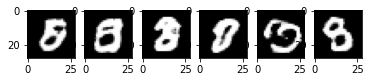

Epoch number: 15000
discriminator loss: 0.27 discriminator acc: 91.8 %
gan loss: 0.83


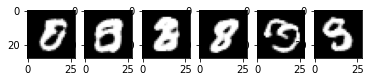

INFO:tensorflow:Assets written to: gen_15000/assets
Epoch number: 15500
discriminator loss: 0.15 discriminator acc: 94.14 %
gan loss: 5.69


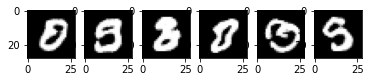

Epoch number: 16000
discriminator loss: 0.15 discriminator acc: 94.53 %
gan loss: 9.91


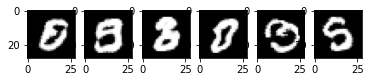

Epoch number: 16500
discriminator loss: 0.16 discriminator acc: 94.14 %
gan loss: 10.11


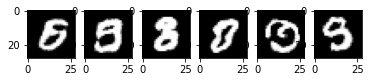

Epoch number: 17000
discriminator loss: 0.13 discriminator acc: 96.48 %
gan loss: 10.33


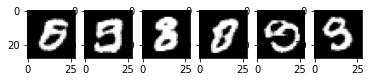

Epoch number: 17500
discriminator loss: 0.15 discriminator acc: 94.14 %
gan loss: 1.48


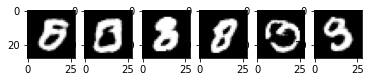

Epoch number: 18000
discriminator loss: 0.2 discriminator acc: 92.19 %
gan loss: 6.8


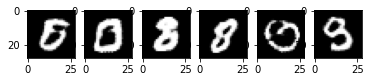

Epoch number: 18500
discriminator loss: 0.24 discriminator acc: 88.67 %
gan loss: 2.22


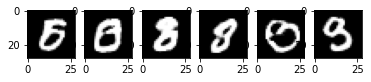

Epoch number: 19000
discriminator loss: 0.22 discriminator acc: 91.41 %
gan loss: 6.77


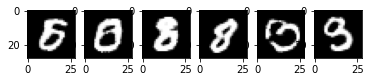

Epoch number: 19500
discriminator loss: 0.23 discriminator acc: 90.23 %
gan loss: 1.17


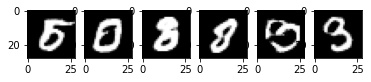

Epoch number: 20000
discriminator loss: 0.18 discriminator acc: 92.19 %
gan loss: 0.08


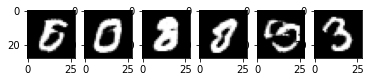

INFO:tensorflow:Assets written to: gen_20000/assets


In [29]:
train_images, d_losses, d_acces, g_losses = [], [], [], []
gan_model, discriminator, generator = create_gan(verbose=True, dropout=True)
for epoch in range(1, n_epochs+1):
    X_real, y_real = select_real_samples(x_train, n_batch)
    X_fake, y_fake = generate_fake_images(generator, latent_dim, n_batch)
    if epoch % print_step == 0:
        print('Epoch number:', epoch)
        print('discriminator loss:', round(d_loss,2), 'discriminator acc:' ,round(d_acc * 100,2),'%')
        print('gan loss:', round(g_loss,2))
        print_images(generator, n_img, seed=0) 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        d_acces.append(d_acc)
    if epoch % save_step == 0:
        generator.save(f'gen_{epoch}')
    X, y = np.vstack([X_real, X_fake]), np.vstack([y_real, y_fake])
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    X_gan = generate_latent_points(latent_dim, n_batch)
    y_gan = np.ones(shape=(n_batch,1))
    g_loss = gan_model.train_on_batch(X_gan, y_gan)

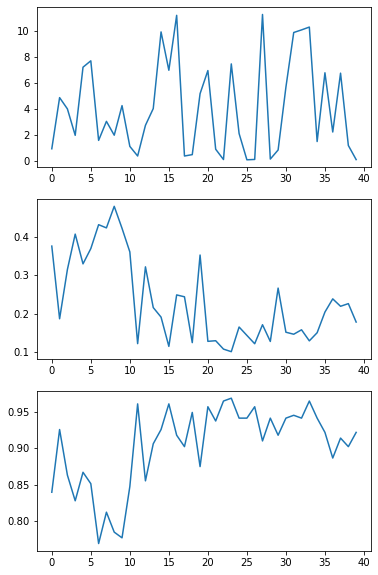

In [30]:
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(6,10))
ax1.plot(g_losses)
ax2.plot(d_losses)
ax3.plot(d_acces)

In [31]:
images = []
for i in range(save_step, n_epochs+save_step, save_step):
    model = keras.models.load_model(f'gen_{i}', compile=False)
    test_image, label = generate_fake_images(model,latent_dim,30,10)
    images.append(test_image)

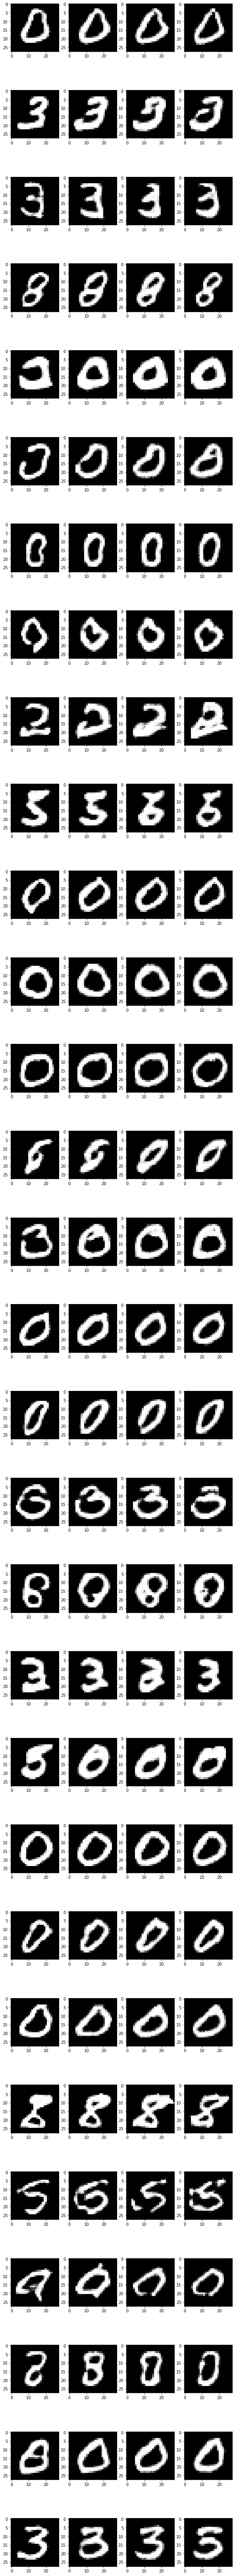

In [32]:
fig, ax = plt.subplots(len(images[0]),len(images), figsize=(10,120))
for en_1, image_list in enumerate(images):
    for en_2, i in enumerate(image_list):
        ax[en_2, en_1].imshow(i, cmap='gray')

In [78]:
model = keras.models.load_model(f'gen_10000', compile=False)

In [79]:
images, label = generate_fake_images(model,latent_dim,n_batch=100,seed=10)

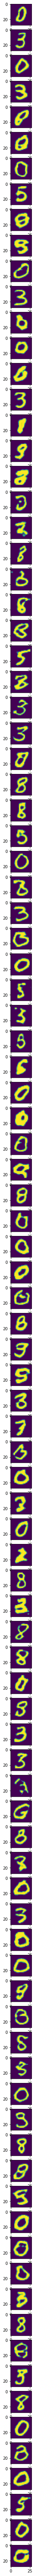

In [80]:
fig, ax = plt.subplots(len(images),1, figsize=(20,120))
for en, i in enumerate(images):
    ax[en].imshow(i)

In [33]:
keras.backend.clear_session()